In [1]:
import numpy as np
import xarray as xr
import pandas as pd
from pyfunctions import *

In [3]:
#############################################
# Setup
nbiomes = 10
npfts = 17
pft_ids = [1,2,3,4,5,6,7,8,10,11,12,13,14,15,16]
pb_index = np.load('pb_index.npy',allow_pickle='TRUE').item()

In [2]:
F_GPP = pd.read_csv("FLUXCOM-GSWP3_GPP_amean_bmean_2001-2010.csv",sep=',')
obs_var = pd.read_csv("FLUXCOM_GPP_amean_bmean_variance.csv",sep=',')
obs_range = pd.read_csv("FLUXCOM_GPP_minmax_amean_bmean_2001-2010.csv",sep=',')

([<matplotlib.axis.XTick at 0x14e945234730>,
 [Text(0.0, 0, 'Ice sheet'),
  Text(1.0, 0, 'Tropical rain forest'),
  Text(2.0, 0, 'Tropical seasonal forest/savanna'),
  Text(3.0, 0, 'Subtropical desert'),
  Text(4.0, 0, 'Temperate rain forest'),
  Text(5.0, 0, 'Temperate seasonal forest'),
  Text(6.0, 0, 'Woodland/shrubland'),
  Text(7.0, 0, 'Temperate grassland/desert'),
  Text(8.0, 0, 'Boreal forest'),
  Text(9.0, 0, 'Tundra')])

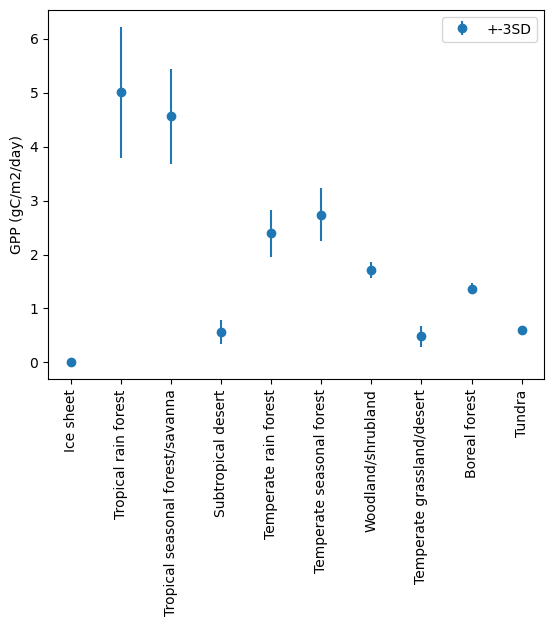

In [6]:
plt.errorbar(F_GPP.biome, F_GPP.GPP, yerr=np.sqrt(obs_var.GPP)*3, fmt="o",label='+-3SD')
plt.legend()
plt.ylabel('GPP (gC/m2/day)')
plt.xticks(F_GPP.biome, F_GPP.biome_name, rotation=90)

### GPP biome total

In [7]:
gpp_pxb=xr.open_dataset('gpp_amean_pxb_2001-2010_v2.nc')

In [13]:
whit = xr.open_dataset('../whit/whitkey.nc')
la = get_la()
biome_la = la.groupby(whit.biome).sum()

In [10]:
f='/glade/work/djk2120/ppe_savs/pbmean/sg_lapxb.nc'
lapxb=xr.open_dataset(f).lapxb
ix=(lapxb.pxb>9)&(lapxb.mean(dim='year').sum(dim='pft')>0)
pxb_la = lapxb.isel(pxb=ix).sum(dim='pft')
pb_la = pxb_la.sel(year=slice(2001,2010)).mean(dim='year').compute()

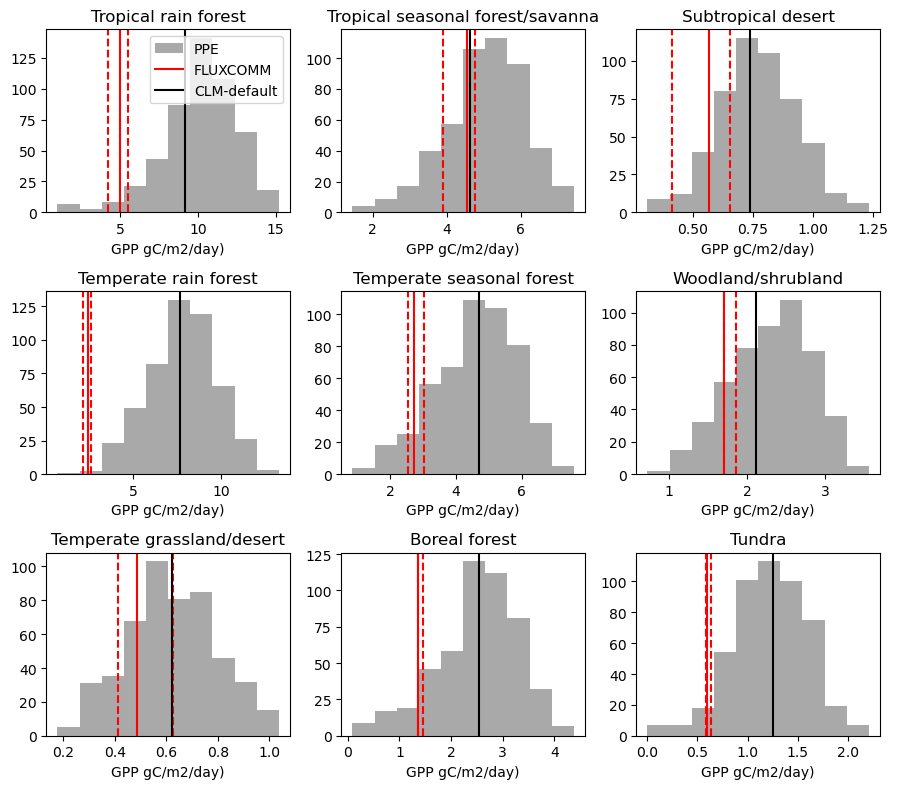

In [39]:
plt.figure(num=None, figsize=(9, 8), dpi=100, facecolor='w', edgecolor='k')
scaler = 60*60*24
dapb = gpp_pxb

for b in range(1,10):
    biome_total = scaler*(1/biome_la[b])*((pb_la.isel(pxb=dapb.biome==b))*(dapb.isel(pxb=dapb.biome==b))).sum(dim='pxb').compute()
    biome_obs = F_GPP.GPP[b]
    biome_obs_min = obs_range.GPPmin[b]
    biome_obs_max = obs_range.GPPmax[b]
    biome_default = biome_total.GPP.sel(ens=0).values.flatten()[0]

    plt.subplot(3,3,b)
    plt.hist(biome_total.GPP,color='darkgrey',label='PPE')
    plt.axvline(x=biome_obs, color='red', linestyle='-',label='FLUXCOMM')
    plt.axvline(x=biome_obs_min, color='red', linestyle='--')
    plt.axvline(x=biome_obs_max, color='red', linestyle='--')
    plt.axvline(x=biome_default, color='k',linestyle='-',label='CLM-default')
    plt.title(F_GPP.biome_name[b])
    plt.xlabel('GPP gC/m2/day)')
    if b==1:
        plt.legend()

plt.tight_layout()
plt.savefig('./figs/GPP_biome_ensemble.png')

### LAI

In [13]:
# Setup
whit=xr.open_dataset('whit/whitkey.nc')
biome_names = whit.biome_name.values
pfts=xr.open_dataset('/glade/campaign/asp/djk2120/PPEn11/paramfiles/OAAT0000.nc').pftname
pft_names=[str(p)[2:-1].strip() for p in pfts.values]

pb_index = np.load('pb_index.npy',allow_pickle='TRUE').item()

In [2]:
SP_LAI_max = xr.open_dataset("CLM-SP_LAI_pxb_amax_2003-2007.nc")
SP_LAI_mean = xr.open_dataset("CLM-SP_LAI_pxb_amean_2003-2007.nc")
LAI_var = pd.read_csv("LAI_amax_bmean_variance.csv",sep=',')

In [4]:
laimax_pxb=xr.open_dataset('lai_amax_pxb_2003-2007_v2.nc')

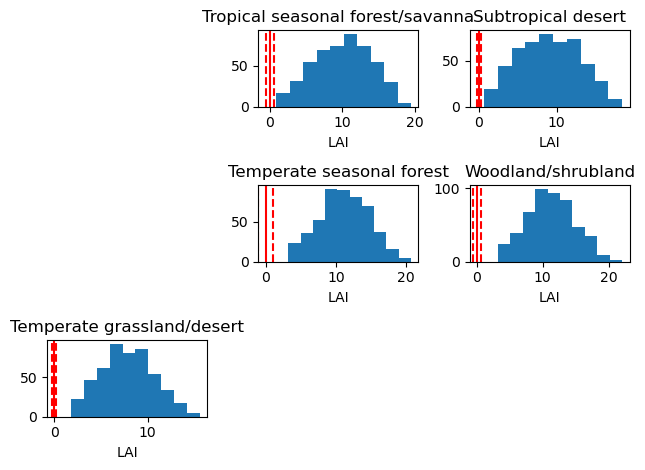

In [43]:
p=16
for b in pb_index[pft_names[p]]:
    pxb = p*10+b
    if (p < 12): # not grass
        o = SP_LAI_max.TLAI.sel(pxb=pxb).values[0]
    else: # grass
        o = SP_LAI_mean.TLAI.sel(pxb=pxb).values[0]
    ovar = LAI_var.TLAI[b]

    lhc = laimax_pxb.TLAI.sel(pxb=pxb).values

    plt.subplot(3,3,b)
    plt.hist(lhc)
    plt.axvline(x=o, color='red', linestyle='-',label='FLUXCOMM')
    plt.axvline(x=o-3*(ovar**0.5), color='red', linestyle='--')
    plt.axvline(x=o+3*(ovar**0.5), color='red', linestyle='--')

    plt.title(biome_names[b])
    plt.xlabel('LAI')
    if b==1:
        plt.legend()
plt.tight_layout()

In [16]:
tmp = laimax_pxb.isel(pxb=pxb)

(array([ 96.,  58., 103.,  91.,  74.,  43.,  22.,  10.,   2.,   2.]),
 array([2.91571478e-08, 1.12779567e+00, 2.25559132e+00, 3.38338696e+00,
        4.51118261e+00, 5.63897825e+00, 6.76677390e+00, 7.89456954e+00,
        9.02236519e+00, 1.01501608e+01, 1.12779565e+01]),
 <BarContainer object of 10 artists>)

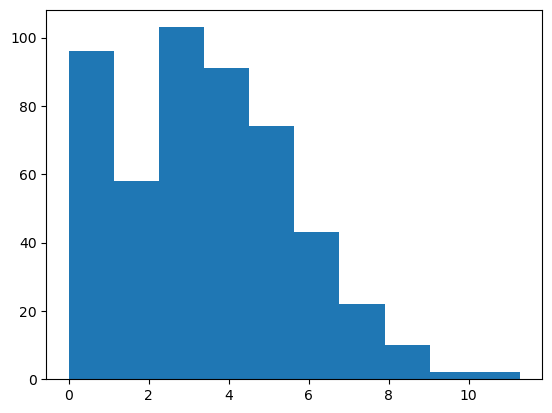

In [17]:
plt.hist(tmp.TLAI.values)

### Emulator uncertainty response surface

In [57]:
import tensorflow as tf
# load parameter sets 
lhckey = '/glade/campaign/asp/djk2120/PPEn11/csvs/lhc220926.txt'
df = pd.read_csv(lhckey)
lhc_params = df.drop(columns='member')
num_params = len(lhc_params.columns)

In [99]:
rn = 500
sample = np.random.rand(rn,num_params)
df_rsamp = pd.DataFrame(sample,columns=lhc_params.columns)

n = 21
s = np.linspace(0,1,n)

out_pred = np.empty([rn,n,n])*np.NaN
out_var = np.empty([rn,n,n])*np.NaN

loaded_emulator = tf.saved_model.load('./models_lai/pft1_biome5')
for i in range(n):
        p1 = np.repeat(s[i],rn)
        for j in range(n):
            p2 = np.repeat(s[j],rn)

            df_rsamp['leafcn'] = p1
            df_rsamp['slatop'] = p2
            samp = df_rsamp.values

            y, y_var = loaded_emulator.predict(samp)

            out_pred[:,i,j] = y.numpy().flatten()
            out_var[:,i,j] = y_var.numpy().flatten()

/glade/derecho/scratch/linnia/tmp/ipykernel_64686/2759648951.py:8: RuntimeWarning: invalid value encountered in multiply
  out_pred = np.empty([rn,n,n])*np.NaN


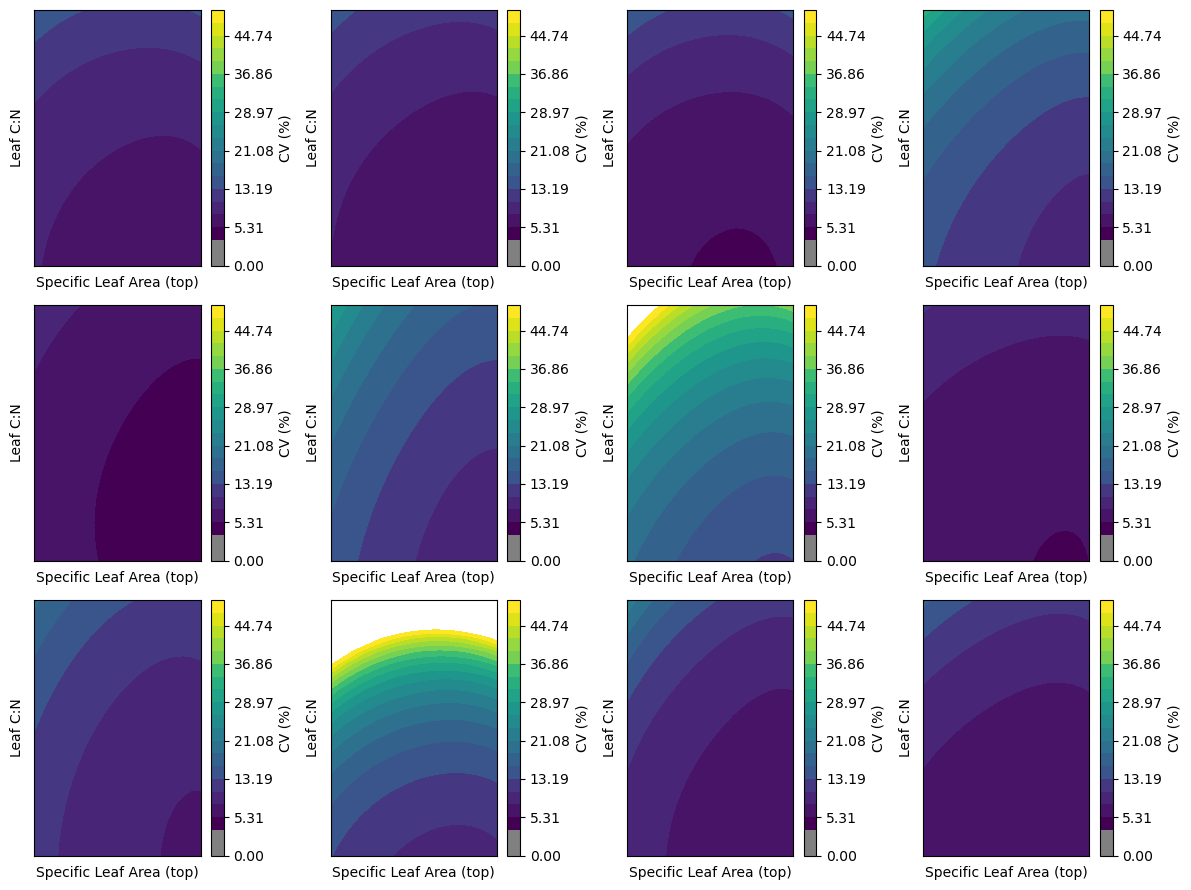

In [79]:
from matplotlib.colors import ListedColormap
plt.figure(figsize=[12,9])


for set in range(12):
    plt.subplot(3,4,set+1)
    data = ((out_var[set,:,:]**0.5)/out_pred[set,:,:])*100
    
    # Specify contour levels
    contour_levels = np.linspace(0.05, 50, 20) # fix this to be even increments
    contour_levels = np.concatenate(([0], contour_levels))
    
    # Create a custom colormap with the first color as grey and the rest from 'viridis'
    custom_cmap_colors = ['grey'] + plt.cm.viridis(np.linspace(0, 1, len(contour_levels)-1)).tolist()
    custom_cmap = ListedColormap(custom_cmap_colors)
    
    # Create a filled contour plot with specified levels and colormap
    plt.contourf(data, levels=contour_levels, cmap=custom_cmap)
    plt.xticks([])
    plt.yticks([])
    # Add colorbar for reference
    plt.colorbar(label='CV (%)')
    
    # Add labels and title
    plt.ylabel('Leaf C:N')
    plt.xlabel('Specific Leaf Area (top)')
    #plt.title('uset'+str(u))
    
plt.tight_layout()
plt.savefig('CV_leafCN_SLATOP_NLETTree_TempSeasonal_forest.png')

In [100]:
data = ((out_var**0.5)/out_pred)*100

In [103]:
data[499,:,1]

array([  24.40303563,   25.66287115,   27.12545588,   28.82932292,
         30.82330918,   33.17026122,   35.9524483 ,   39.27966951,
         43.3017526 ,   48.22848701,   54.36270927,   62.15790913,
         72.32454089,   86.04096344,  105.41272412,  134.60459687,
        183.16645809,  278.8797777 ,  550.93216594, 6512.08609656,
       -717.37404471])

In [88]:
# Stack the last two dimensions (n and p)
# Reshape the array to flatten the last two dimensions
#raveled_array = data.reshape(-1, data.shape[-1])
# Reshape the array to flatten the last two dimensions
raveled_array = data.reshape(data.shape[0], -1)

In [96]:
mx = np.max(raveled_array,axis=1)
mn = np.min(raveled_array,axis=1)

In [97]:
grad = mx-mn

(array([498.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([2.80881964e+00, 4.95332183e+04, 9.90636278e+04, 1.48594037e+05,
        1.98124447e+05, 2.47654856e+05, 2.97185266e+05, 3.46715675e+05,
        3.96246085e+05, 4.45776494e+05, 4.95306904e+05]),
 <BarContainer object of 10 artists>)

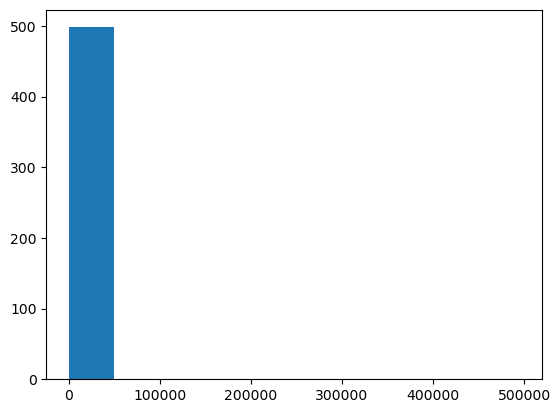

In [109]:
plt.hist(grad)

### Function to score how close a sample is to a Latin Hypercube

In [2]:
def LHC_score(n,nbins,num_params,sample):
    # sample is np array with rows as ensemble members and columns as parameters
    # zero is a perfect Latin Hypercube
    Pb = n/nbins
    dim_count = []
    for di in range(num_params):
        data = sample[:,di]
        bin_count = []
        for bi in range(nbins):
            bin_width = 1/20
            bin_min = bi/nbins
            bin_max = bi/nbins+bin_width
            Ab = np.sum((data>bin_min)&(data<bin_max))
    
            bin_count.append(np.abs(Pb - Ab))
        dim_count.append(np.sum(bin_count))
    
    return np.sum(dim_count)

In [3]:
n = 500
nbins = 20
num_params = 5
sample = np.random.rand(n,num_params)
L = LHC_score(n,nbins,num_params,sample)

In [4]:
L

412.0